In [228]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 11 01:31:27 2019

@author: YuFang
"""
#import required packages
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from matplotlib.patches import Ellipse
from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import multivariate_normal

#prepare the dataset
K=3
NUM_DATAPTS=150
X,y=make_blobs(n_samples=NUM_DATAPTS,centers=K,shuffle=False,random_state=0,cluster_std=0.6)
g1 = np.asarray([[2.0,0],[-0.9,1]])
g2 = np.asarray([[1.4,0],[0.5,0.7]])
mean1=np.mean(X[:int(NUM_DATAPTS/K)])
mean2 = np.mean(X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)])
X[:int(NUM_DATAPTS/K)]=np.einsum('nj, ij -> ni',X[:int(NUM_DATAPTS/K)]-mean1, g1)+mean1
X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)] = np.einsum('nj, ij -> ni',X[int(NUM_DATAPTS/K):2*int(NUM_DATAPTS/K)]-mean2,g2)+mean2

X[:,1]-=4

In [229]:
#4a)

#Randomly initialize a numpy array mu of shape (K,2): to represent the mean of the clusters
mu=np.random.rand(K,2)
#initialize an array cov of shape (K,2,2) such that cov[k] is the identity matrix for each k
#cov will be used to represent the covariance matrices of the clusters
cov=np.random.rand(K,2,2)

for k in range(K):
    cov[k]=np.identity(2)
#set pi to be the uniform distribution at the start of the program
pi=np.random.uniform(size=(K))

#print out all
print("Means:")
print (mu)
print("Covariance:")
print (cov)
print("Pi:")
print (pi)
#%%
#4b)

Means:
[[0.76258173 0.52382282]
 [0.51925884 0.25386796]
 [0.23688826 0.07881942]]
Covariance:
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
Pi:
[0.85903233 0.52477543 0.95783567]


In [230]:
#Write a fxn to perform the E-step:
def E_step():
    gamma=np.zeros((NUM_DATAPTS,K))
    for i in range(NUM_DATAPTS):
        gamma_new=np.zeros(K)
        
        for cluster_j in range(K):
            gamma_new[cluster_j]=pi[cluster_j]* multivariate_normal.pdf(X[i], mu[cluster_j], cov[cluster_j])
            
        # denominator of gamma
        total_gamma=0
        for cluster_j in range(K):
            total_gamma+=pi[cluster_j]*multivariate_normal.pdf(X[i], mu[cluster_j], cov[cluster_j])
        
        for cluster_j in range(K):
            gamma[i,cluster_j]=gamma_new[cluster_j]/total_gamma
            
    return gamma

In [276]:
a = M_step(gamma)
b = M_step1(gamma)
print(a[1])
print(b[1])

[[[ 3.34296963 -1.87923344]
  [-1.87923344  3.85032592]]

 [[ 2.9784378  -1.03841389]
  [-1.03841389  1.4973106 ]]

 [[ 1.58253449 -0.64033327]
  [-0.64033327  3.41980127]]]
[[[ 3.34296963 -1.87923344]
  [-1.87923344  3.85032592]]

 [[ 2.9784378  -1.03841389]
  [-1.03841389  1.4973106 ]]

 [[ 1.58253449 -0.64033327]
  [-0.64033327  3.41980127]]]


In [279]:
#4c)
#Write a fxn to perform the M-step:
def M_step(gamma):
    mu = np.zeros((3,2))
    cov = np.zeros((K,2,2))
    
    gamma_forM=np.sum(gamma,axis=0) # [N_0, N_1, N_2]
    for k in range(K):
        #find pi
        pi[k]=1/NUM_DATAPTS*gamma_forM[k] # replace old pi with new pi
        
        # for every data point
        for i in range(NUM_DATAPTS):
            #find mean
            mu[k]+=X[i]*gamma[i,k]/gamma_forM[k] # remove the sum
        for i in range(NUM_DATAPTS):
            #find cov
            cov[k]+=(gamma[i,k]*(X[i]-mu[k]).reshape(2,1)@(X[i]-mu[k]).reshape(1,2))/gamma_forM[k]

    return pi,cov,mu

In [280]:
def M_step1(gamma):
    N_effect = np.sum(gamma, axis=0)
    MEANS = np.array([
        (1/N_effect[cluster_idx]) * sum([gamma[i, cluster_idx]*X[i] for i in range(NUM_DATAPTS)])
              for cluster_idx in range(K)])
    
    COVARIANCES = np.zeros((3,2,2))
    for cluster_idx in range(K):
        mean = MEANS[cluster_idx]       
        sigma_k = 0
        for i in range(NUM_DATAPTS):
            x = X[i]
            x_minus_mu = (x - mean).reshape(-1,1)
            sigma_k += gamma[i, cluster_idx]*x_minus_mu@(x_minus_mu.T)            
        COVARIANCES[cluster_idx] = (1/N_effect[cluster_idx] * sigma_k)

    CLUSTER_COEFFICIENTS = [N_k/NUM_DATAPTS for N_k in N_effect]
    
    return CLUSTER_COEFFICIENTS, COVARIANCES, MEANS
          
#4d)
    

In [281]:
#write a loop that iterates through E and M steps
#that terminates after the change in log-likelihood is below some threshold
def plot_result(gamma=None):
    ax = plt.subplot(111, aspect='equal')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.scatter(X[:, 0], X[:, 1], c=gamma, s=50, cmap=None)
    
    for k in range(K):
        l, v = LA.eig(cov[k])
        theta = np.arctan(v[1,0]/v[0,0])
        e = Ellipse((mu[k,0],mu[k,1]),6*l[0],6*l[1],theta*180/np.pi)
        e.set_alpha(0.5)
        ax.add_artist(e)
    plt.show()
 
    
def log_likelihood(X,pi,cov,mu):
    # calculates me log likelihood!
    logLikelihood = 0
    LL = np.zeros((NUM_DATAPTS, K))
    for i in range(NUM_DATAPTS):
        for cluster_j in range(K):
            LL[i,cluster_j] = pi[cluster_j] * multivariate_normal.pdf(X[i], mu[cluster_j], cov[cluster_j]) 
        new_LL = np.sum(np.log(np.sum(LL, axis=1)))
    return new_LL



START


LL
-596.251081921823
Improved
inf


/home/adam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


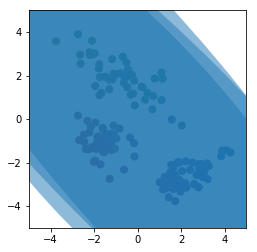

LL
-595.3702403175105
Improved
0.8808416043125362


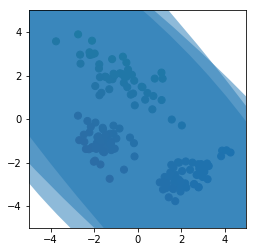

LL
-594.0534328082756
Improved
1.3168075092348772


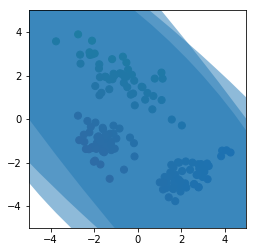

LL
-591.7605858078958
Improved
2.2928470003797656


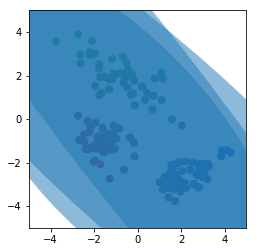

LL
-587.3384646210498
Improved
4.422121186846084


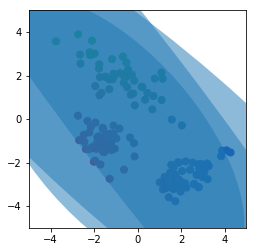

LL
-577.8814388469752
Improved
9.45702577407451


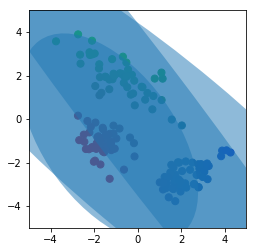

LL
-557.8159346756487
Improved
20.065504171326552


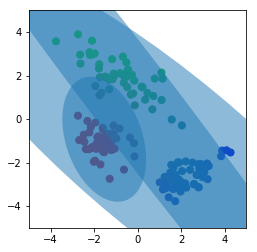

LL
-536.429900231895
Improved
21.386034443753715


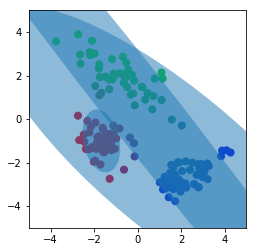

LL
-520.5789044849895
Improved
15.850995746905483


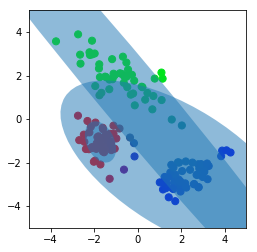

LL
-497.2479757313181
Improved
23.3309287536714


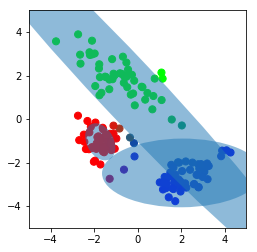

LL
-477.57467374159125
Improved
19.673301989726838


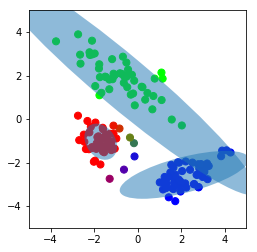

LL
-465.04930144058443
Improved
12.525372301006826


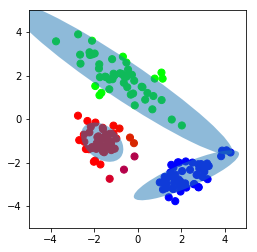

LL
-463.3425889825829
Improved
1.7067124580015047


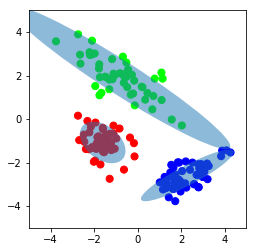

LL
-463.3419445472671
Improved
0.0006444353158485683


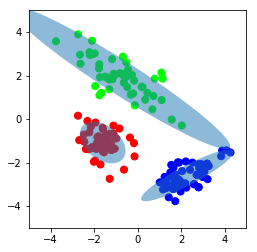

LL
-463.3419435721662
Improved
9.75100874711643e-07


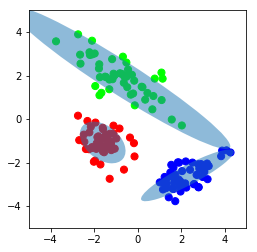

LL
-463.34194356831017
Improved
3.8560301618417725e-09


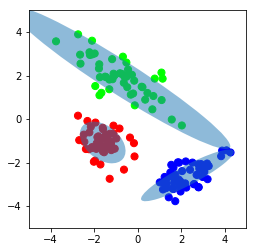

LL
-463.3419435682948
Improved
1.5347723092418164e-11


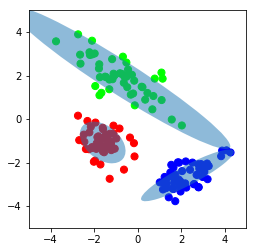

LL
-463.34194356829465
Improved
1.7053025658242404e-13


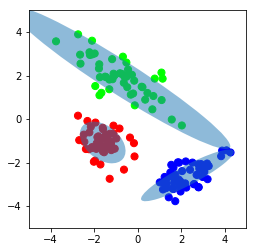

LL
-463.3419435682947
Improved
-5.684341886080802e-14


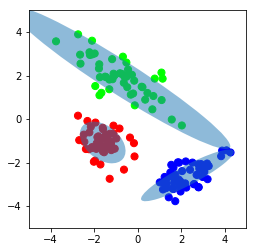

LL
-463.34194356829477
Improved
-5.684341886080802e-14


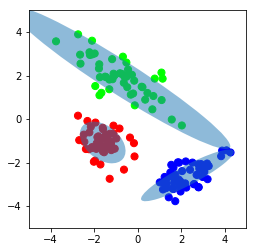

In [282]:
#4a)

#Randomly initialize a numpy array mu of shape (K,2): to represent the mean of the clusters
mu=np.random.rand(K,2)
#initialize an array cov of shape (K,2,2) such that cov[k] is the identity matrix for each k
#cov will be used to represent the covariance matrices of the clusters
cov=np.random.rand(K,2,2)

for k in range(K):
    cov[k]=np.identity(2)
#set pi to be the uniform distribution at the start of the program
pi=np.random.uniform(size=(K))

#%%
#4b)
print("\n\nSTART\n\n")
Max_iterations=20;
prev_LL=-np.inf
for M in range(Max_iterations):
    gamma=E_step()
    pi,cov,mu=M_step(gamma)
    new_LL=log_likelihood(X,pi,cov,mu)
    print("LL")
    print(new_LL)
    Improve=new_LL-prev_LL
    print("Improved")
    print(Improve)
    prev_LL = new_LL
    plot_result(gamma)